## Text Classification with Word2Vec Embeddings

In [68]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import KeyedVectors
import gensim

In [8]:
## Reading the input
input_file = r'C:\Users\hp\Documents\Documents_Laiba\NLP_PROJECT\subtaska-combined-preprocessed-train.data'

In [30]:
import csv 
import re

with open(input_file, "r", encoding='utf-8') as f:
    reader = csv.reader(f, delimiter="\t")
    lines = []
  
    for line in reader:
       
        if line[3] == 'tweet':
             continue
        p_line = []
        p_line.append(line[3])
        
        if line[4] == 'NOT':
            replaced = re.sub('NOT' , '0' , line[4])
            p_line.append(replaced)
        if line[4] == 'OFF':
            replaced = re.sub('OFF' , '1' , line[4])
            p_line.append(replaced)    
        lines.append(p_line)

In [12]:
lines[0]

['Millions of life have been ruined by the jahil kom', '1']

In [13]:
len(lines)

24306

In [14]:
df = pd.DataFrame(lines)

In [16]:
df.head()

,0,1
0,Millions of life have been ruined by the jahil...,1
1,Cheater,1
2,Nice Initiative Sir .. I don't understand why ...,0
3,@USER Jacob stand there in his own garden and ...,0
4,Leaving the industry should be her decision no...,0


In [17]:
df = df.rename(columns = { 0 : "Tweet"  , 1 : "Class"})

In [24]:
## Checking the distribution of classes
no_off = len(df[df['Class'] == '1'])
print("Number of offensive tweets : " , no_off)

Number of offensive tweets :  11811


In [31]:
no_non_off = len(df[df['Class'] == '0'])
print("Number of non offensive tweets : " , no_non_off)

Number of non offensive tweets :  12495


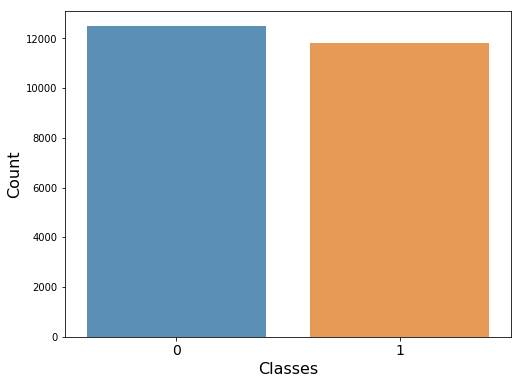

In [43]:
count_classes = df['Class'].value_counts()
x = [ i for i in range( len(count_classes.index) )]

plt.figure(figsize = ( 8 , 6 ) )
sns.barplot(count_classes.index , count_classes.values , alpha = 0.8)
plt.ylabel('Count' , fontsize = 16 )
plt.xlabel('Classes' , fontsize = 16 )
plt.xticks( x , count_classes.index , fontsize = 14 , rotation = 0)
plt.show()

## Classes are balanced

In [44]:
train_df = df[:20000]
test_df = df[20000:]

In [49]:
train_data_list = [ x for x in train_df['Tweet']]
test_data_list = [ x for x in test_df['Tweet']]

y_train_cat = to_categorical(train_df.Class)
y_test_cat = to_categorical(test_df.Class)

In [53]:
#tokenising 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_list)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

29821


In [54]:
encoded_docs_train = tokenizer.texts_to_sequences(train_data_list)
encoded_docs_test = tokenizer.texts_to_sequences(test_data_list)

In [55]:
lengths = [len(s.split()) for s in train_data_list]
max_length = max(lengths)
print(max_length)

1340


In [61]:
max_length = 1340
padded_docs_train = pad_sequences(encoded_docs_train, maxlen = max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen = max_length, padding='post')

In [62]:
X_train = padded_docs_train
X_test = padded_docs_test

In [63]:
print(X_train.shape , X_test.shape)

(20000, 1340) (4306, 1340)


In [65]:
print(y_train_cat.shape , y_test_cat.shape)

(20000, 2) (4306, 2)


In [70]:
filename_pmc = r'G:\Laiba_HP_Excess\1st_April\Word_embeddings\GoogleNews-vectors-negative300.bin'
model_pmc = gensim.models.KeyedVectors.load_word2vec_format( filename_pmc  , binary=True)

In [71]:
EMBEDDING_DIM = 300
vocabulary_size =  vocab_size

embedding_matrix_pmc = np.zeros(( vocabulary_size , EMBEDDING_DIM ))
for word , i in tokenizer.word_index.items():
    try:
        embedding_vector_pmc = model_pmc[word]
    except KeyError:
        embedding_vector_pmc = None
    if embedding_vector_pmc is not None:
        embedding_matrix_pmc[i] = embedding_vector_pmc

In [73]:
import keras
import keras.backend as K
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.callbacks import EarlyStopping
from keras.models import Sequential

In [86]:
from keras.models import Sequential

model = Sequential()
model.add(Embedding( vocab_size , 300 , weights = [embedding_matrix_pmc] ,  input_length = max_length , trainable = False))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1340, 300)         8946300   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 9,023,870
Trainable params: 77,570
Non-trainable params: 8,946,300
_________________________________________________________________


In [88]:
model.fit( X_train , y_train_cat , validation_split = 0.10 )

Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 35s 2ms/step - loss: 0.6616 - acc: 0.6127 - val_loss: 0.6445 - val_acc: 0.6800


In [82]:
len(X_train[7434])

1340

In [89]:
predictions_out = model.predict( X_test )

In [90]:
predictions_out.shape

(4306, 2)

In [91]:
outputs = np.argmax( predictions_out , axis = 1)

In [102]:
y_true = np.argmax(y_test_cat , axis = 1)

In [103]:
from sklearn.metrics import accuracy_score

print(accuracy_score( y_true , outputs  ))

0.6820715281003251
